In [1]:
import os
import pandas as pd
import empyrical as ep

In [2]:
import matplotlib as  mpl
mpl.rcParams['font.sans-serif']= ['SimHei']                 # for Chinese display
mpl.rcParams['axes.unicode_minus'] = False  
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
os.chdir('F:\\Frame-sync-w-Zhongyu')

In [4]:
from data_manager.BasicsDataManager import BasicsDataManager
from data_manager.DailyDataManager import DailyDataManager
from data_manager.IndustryDataManager import IndustryDataManager
from data_manager.CommodityPoolManager import CommodityPoolManager
from data_manager.ContDominantDataManager import ContDominantDataManager
from data_manager.FactorDataManager import FactorDataManager

import backtester.weights_utils as wu
import qtgQuants.alphalens as al
import qtgQuants.pyfolio as pf

import utils.clean_and_test as ct
import utils.metrics_utils as mu
import utils.analysis_and_plot as ap

F:\Frame-sync-w-Zhongyu\qtgQuants\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [5]:
bdm = BasicsDataManager()
ddm = DailyDataManager()
idm = IndustryDataManager()
cpm = CommodityPoolManager()
cddm = ContDominantDataManager()
fdm = FactorDataManager()

In [6]:
factor_instace = fdm.get_factor(group='CarryFactor', name='MainNearFactor1',
                                price='close',
                                window=1,
                                delist=0,
                                filterby='volume',
                                others='second')
factor_value = factor_instace.get_factor_value()

In [7]:
group = idm.get_symbol_industry_map(group='actual_industry', name='actual_five_industry')
commodity_pool_instance = cpm.get_commodity_pool(group='DynamicPool', name='DynamicPool5',
                                                 window=20,
                                                 warm_up_days=126,
                                                 entry_only=0,
                                                 min_value=10000,
                                                 filterby='volume',
                                                 exclusionList='ExclusionList3')
commodity_pool_mask = commodity_pool_instance.get_commodity_pool_value()

In [8]:
exclusion_list = []
group_list_after_exclusion = set(group.keys()) - set(exclusion_list)
symbol_list = factor_instace.get_symbol_list()  # original full symbol list
# TODO: check to set grouping gradually with new symbols
symbol_list_wo_grouping = set(symbol_list) - set(group.keys())
commodity_pool_mask = commodity_pool_mask.filter(items=group_list_after_exclusion)
factor_value = factor_value[commodity_pool_mask]
factor_value = factor_value.stack()

In [9]:
factor_value

datetime    underlying_symbol
2009-07-13  A                    0.038766
            AL                   0.004517
            AU                  -0.014242
            C                   -0.044011
            CF                   0.049973
                                   ...   
2021-06-30  UR                   0.140609
            V                    0.194787
            Y                    0.065921
            ZC                   0.164851
            ZN                   0.008198
Length: 86428, dtype: float64

In [10]:
prices = cddm.get_cont_dominant_data_by_field(contract='main', price='close', rebalance_days=1,
                                              style='k', field='continuous_price')
periods = (1, 5, 10)
factor_data1 = al.utils.get_clean_factor_and_forward_returns(factor=factor_value,
                                                            prices=prices,          # has to be wide-form
                                                            groupby=group,
                                                            binning_by_group=False,
                                                            quantiles=5,  # default 5 groups
                                                            bins=None,
                                                            periods=[1,5,10,15,20,25,30,35,40],  # default multi-periods
                                                            filter_zscore=20,
                                                            groupby_labels=None,
                                                            max_loss=0.35,
                                                            zero_aware=False,
                                                            cumulative_returns=True)
factor_data2 = al.utils.get_clean_factor_and_forward_returns(factor=factor_value,
                                                            prices=prices,          # has to be wide-form
                                                            groupby=group,
                                                            binning_by_group=False,
                                                            quantiles=5,  # default 5 groups
                                                            bins=None,
                                                            periods=[1],  # default multi-periods
                                                            filter_zscore=20,
                                                            groupby_labels=None,
                                                            max_loss=0.35,
                                                            zero_aware=False,
                                                            cumulative_returns=True)


Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-2.723915,0.012571,-0.164646,0.173795,18387,21.287410
2,-0.183083,0.090420,-0.050464,0.029722,16790,19.438495
3,-0.131359,0.146834,-0.008274,0.032168,16528,19.135166
4,-0.093596,0.335583,0.048886,0.050707,16787,19.435022
5,-0.059200,1.525985,0.186985,0.133333,17883,20.703907


Returns Analysis Factor Weighted and Equal Weighted Long/Short/demeaned 


,1D
Ann. alpha (Factor_weighted),0.087
beta (Factor_weighted),0.071
Ann. alpha (Equal_weighted),0.055
beta (Equal_weighted),0.051
Mean Period Wise Return Top Quantile (bps) - RateRet,3.378
Mean Period Wise Return Bottom Quantile (bps) - RateRet,-3.856
Mean Period Wise Spread Top-Bot (bps) - RateRet,7.233
Std. of Period Wise Spread Top-Bot (bps) - RateRet,87.990


<Figure size 864x432 with 0 Axes>

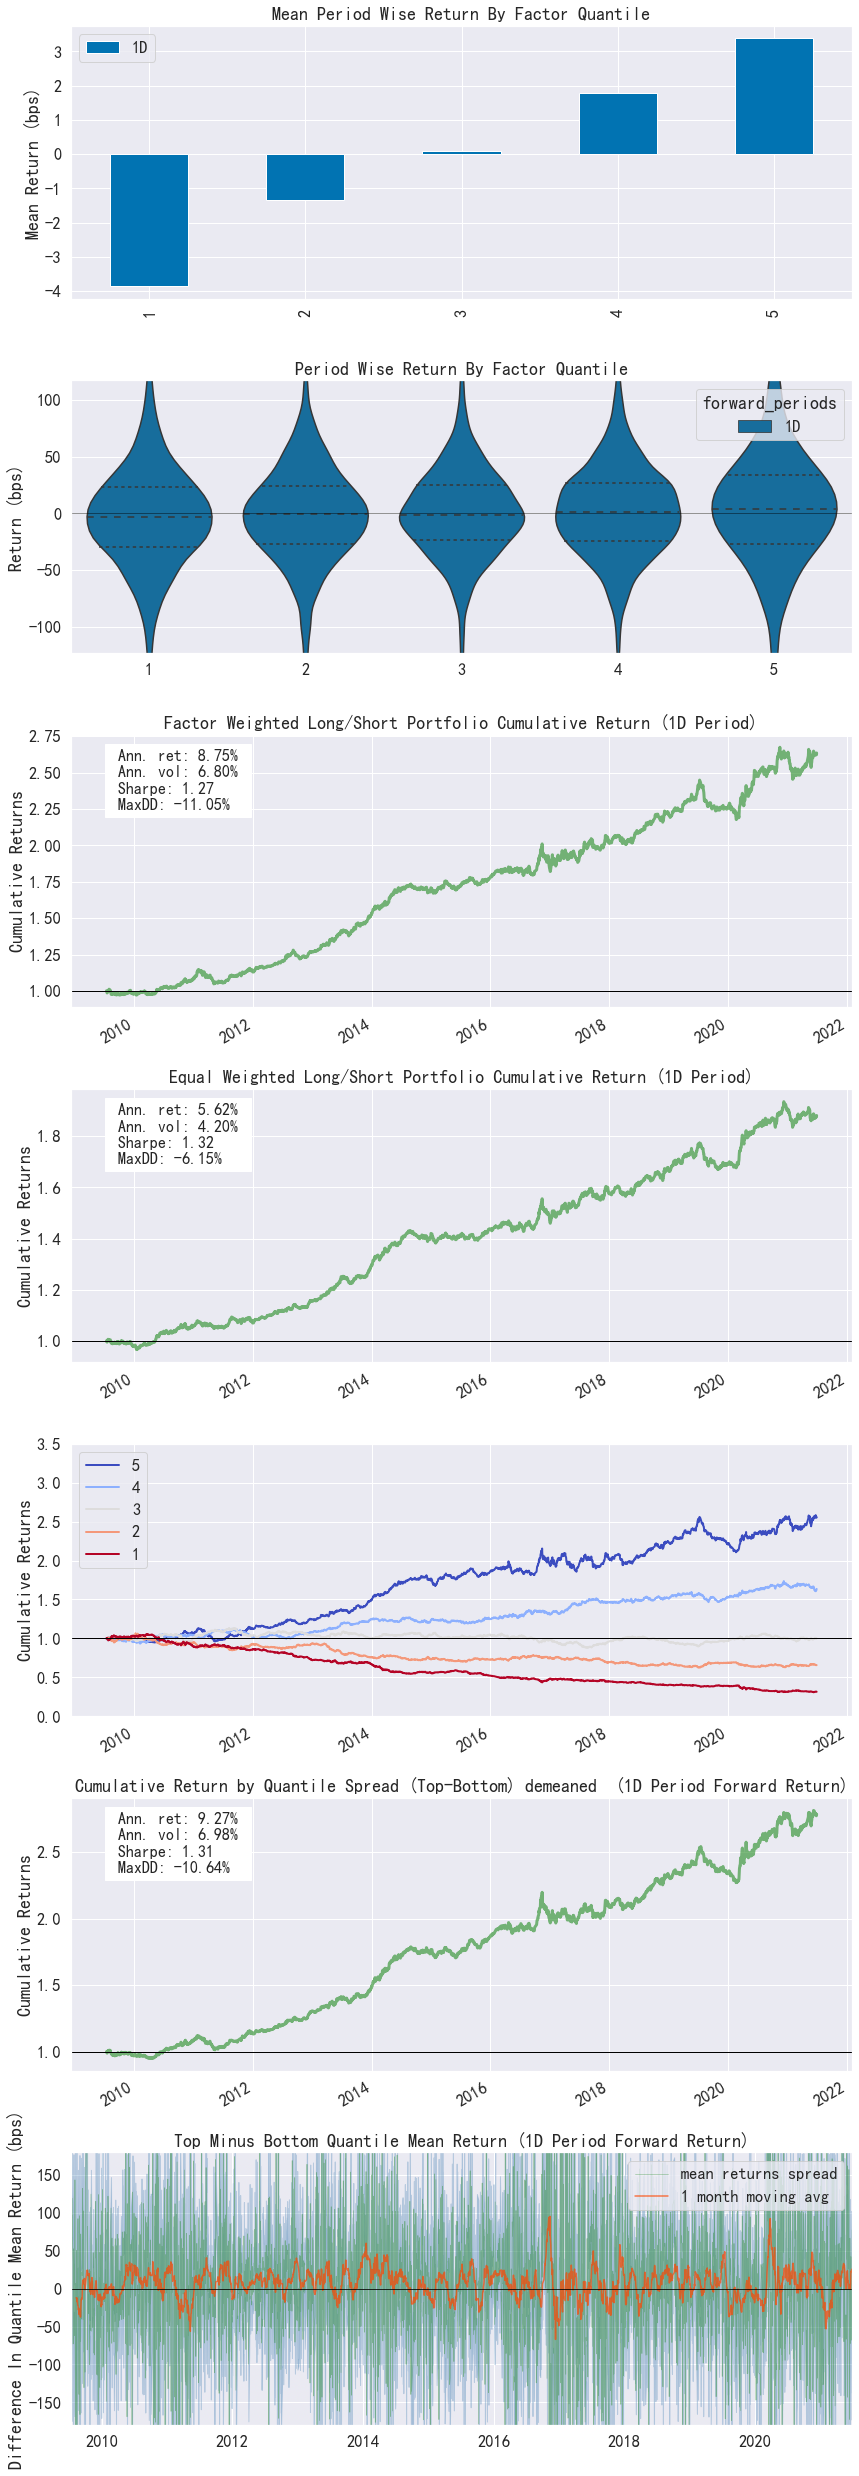

Information Analysis


,1D
IC Mean,0.032
IC Std.,0.254
Risk-Adjusted IC(ICIR),0.128
t-stat(IC),6.886
p-value(IC),0.000
IC Skew,-0.033
IC Kurtosis,-0.318


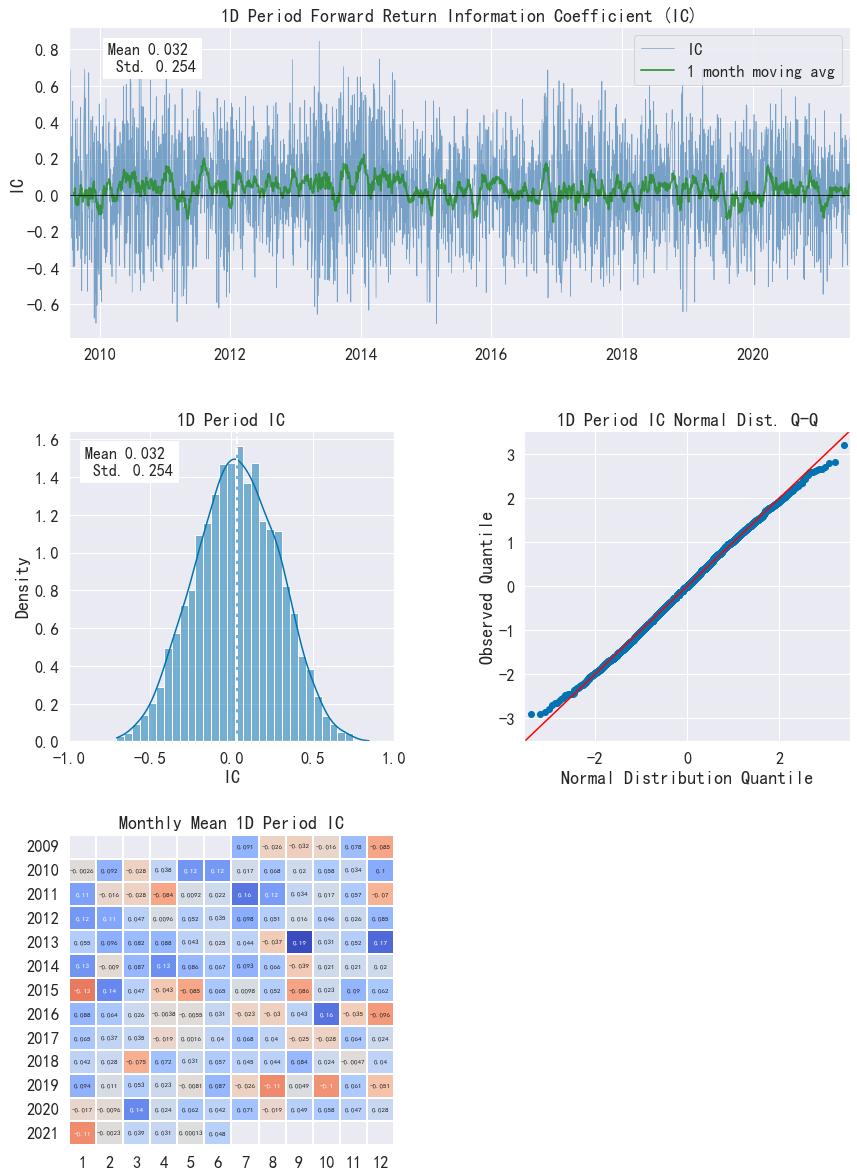

Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.114
Quantile 2 Mean Turnover,0.245
Quantile 3 Mean Turnover,0.261
Quantile 4 Mean Turnover,0.220
Quantile 5 Mean Turnover,0.101


,1D
Mean Factor Rank Autocorrelation,0.958


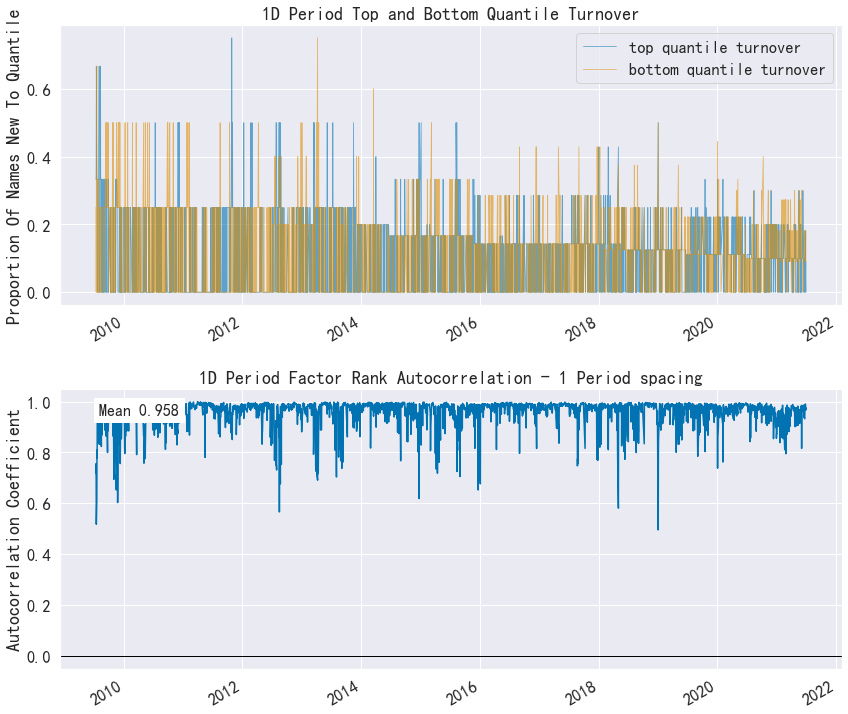

In [11]:
al.tears.create_full_tear_sheet(factor_data2,long_short=True,group_neutral=False,by_group=False)

In [12]:
weights_value1 = wu.equal_weights_from_quantiles(factor_data=factor_data1,
                                              long_quantiles=[5],
                                              short_quantiles=[1],
                                               demeaned=True)

In [13]:
freq1 = factor_data1.index.levels[0].freq

In [14]:
periods1=['5D','10D','15D','20D','25D','30D','35D','40D']

## 全时段

stats_to_2021_F=[]
stats_to_2021_T=[]
cumret_to_2021_F=[]
cumret_to_2021_T=[]
for period in periods1:
    cum_ret_dep1_F,ret_dep1_F = mu.dependent_cum_ret_wo_fee(factor_data1,weights_value1,period,freq1,leverage_up =False,commission_rate =0.0003)
    #cum_ret_dep2_F,ret_dep2_F = mu.dependent_cum_ret_wo_fee(factor_data2,weights_value2,period,freq2,leverage_up =False,commission_rate =0.0003)
    cum_ret_dep1_T,ret_dep1_T = mu.dependent_cum_ret_wo_fee(factor_data1,weights_value1,period,freq1,leverage_up =True,commission_rate =0.0003)
    #cum_ret_dep2_T,ret_dep2_T = mu.dependent_cum_ret_wo_fee(factor_data2,weights_value2,period,freq2,leverage_up =True,commission_rate =0.0003)
    stats_to_2021_F.append(ap.show_simple_stats(ret_dep1_F))
    stats_to_2021_T.append(ap.show_simple_stats(ret_dep1_T))
    cumret_to_2021_F.append(cum_ret_dep1_F)
    cumret_to_2021_T.append(cum_ret_dep1_T)

stats_to_2021_F=pd.concat(stats_to_2021_F,axis=1)
stats_to_2021_F.columns=periods1
stats_to_2021_F

stats_to_2021_T=pd.concat(stats_to_2021_T,axis=1)
stats_to_2021_T.columns=periods1
stats_to_2021_T

## 全时段离散性

In [15]:
cum_ret_list_indep=[]
stats_indep=[]
period='40D'
result = mu.create_period_portfolio_series(ret = factor_data2['1D'], weights=weights_value2, period='40D',commission_rate=0.0003)
all_ret = mu.get_field_level_data(result, group, period='40D', field='profit', level='all',by_date=True, detail=True)
all_comm =mu.get_field_level_data(result, group, period='40D', field='commission', level='all',by_date=True, detail=True)
ret_wo_fee=[]
for i in range(40):
    sub_ret = all_ret[i]
    sub_comm = all_comm[i]
    sub_ret_wo_fee = sub_ret-sub_comm
    ret_wo_fee.append(sub_ret_wo_fee)
ret_wo_fee = pd.concat(ret_wo_fee,axis=1)
stats4=[]
for i in range(40):
    stats4.append(ap.show_simple_stats(ret_wo_fee[i]))
stats4=pd.concat(stats4,axis=1)
stats4.columns = range(40)
stats4

NameError: name 'weights_value2' is not defined

In [ ]:
stats4.iloc[3,:].plot(kind='bar')
plt.axhline(1.168, linestyle='-', color='black', lw=1,label='No Leverage')
plt.axhline(1.048, linestyle='-', color='red', lw=1,label='Leverage')
plt.legend()

In [ ]:
(ret_wo_fee+1).cumprod().reset_index(1,drop=True).iloc[-1,:].plot(kind='bar')
plt.axhline(1.74, linestyle='-', color='black', lw=1,label='No Leverage')
plt.axhline(1.88, linestyle='-', color='red', lw=1,label='Leverage')
plt.legend()

In [ ]:
for period in periods1:
    al.performance.positions(weights_value2, period, freq=freq2, leverage_up=False)[1].plot(label=period,ylim=(0.9,2.5))
plt.legend()

In [ ]:
pd.concat(cumret_to_2021_T,axis=1).plot()

In [ ]:
pd.concat(cumret_to_2021_F,axis=1).plot()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(22,8))
a = pd.concat(cumret_to_2021_T,axis=1)
a.columns = periods1
a.plot(title='Leverage_up=True',ax=axs[0],ylim=(0.9,2.2))
b = pd.concat(cumret_to_2021_F,axis=1)
b.columns = periods1
b.plot(title='Leverage_up=False',ax=axs[1],ylim=(0.9,2.2))